<a href="https://colab.research.google.com/github/pankajr141/experiments/blob/master/Reasoning/ComputerVision/super_resolution_enhancing_image_quality_using_pretrained_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Introduction

we will look into some of the technique and algos using which we can enhance the quality of old low resolution images.

## Setting up Environment

### Upgrade Libraries

In [ ]:
!pip install opencv-contrib-python --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import cv2
cv2.__version__

'4.6.0'

### Mount Gdrive and download datasets

* Download kaggle json to download dataset
* Upload the new dataset to drive
* Copy the Authentication json for kaggle to download our datasets, 1 time activity

In [ ]:
''' Link to explain how to download Datasets from kaggle https://www.kaggle.com/general/74235'''

!pip install -q kaggle
!mkdir ~/.kaggle
!cp '/content/drive/MyDrive/Kaggle/kaggle.json' ~/.kaggle
!chmod 600 ~/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [ ]:
%%time
!kaggle datasets download -d scribbless/another-anime-face-dataset -p dataset
!unzip -q dataset/another-anime-face-dataset.zip -d dataset/another-anime-face-dataset
!rm dataset/another-anime-face-dataset.zip

 99% 1.43G/1.44G [00:39<00:00, 60.9MB/s]
100% 1.44G/1.44G [00:39<00:00, 39.1MB/s]
CPU times: user 694 ms, sys: 116 ms, total: 809 ms
Wall time: 1min 3s


In [ ]:
import os
dir_dataset =  'dataset/another-anime-face-dataset/animefaces256cleaner'
files_img = [os.path.join(dir_dataset, x) for x in os.listdir(dir_dataset)]

In [ ]:
len(files_img), files_img[0: 4]

(92219,
 ['dataset/another-anime-face-dataset/animefaces256cleaner/97468344_result.jpg',
  'dataset/another-anime-face-dataset/animefaces256cleaner/1152774_result.jpg',
  'dataset/another-anime-face-dataset/animefaces256cleaner/42320823_result.jpg',
  'dataset/another-anime-face-dataset/animefaces256cleaner/30112073_result.jpg'])

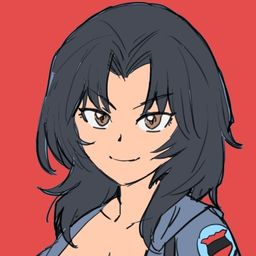

In [ ]:
from google.colab.patches import cv2_imshow
import cv2

img = cv2.imread(files_img[201], cv2.IMREAD_UNCHANGED)
cv2_imshow(img)

### Downsample images

> Here we are going to write some downsampling code through which we are going to generate some low resolution images

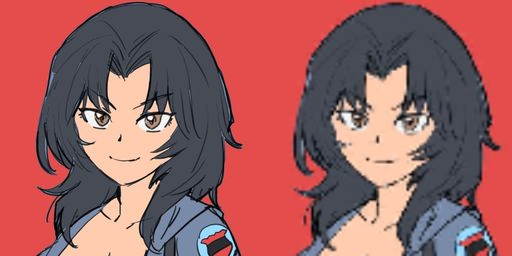

In [ ]:
import numpy as np

def downsample(img_file, scale=0.3, plot=False):
    img = cv2.imread(img_file, cv2.IMREAD_UNCHANGED)
    img_small = cv2.resize(img, (0,0), fx=scale, fy=scale, interpolation = cv2.INTER_NEAREST)

    if plot:
        img_small_resize = cv2.resize(img_small, (img.shape[0], img.shape[1]))
        cv2_imshow(np.hstack([img, img_small_resize]))
    return img, img_small

_, img_small = downsample(files_img[201], scale=0.4, plot=True)

In [ ]:
files_img[0]

'dataset/another-anime-face-dataset/animefaces256cleaner/97468344_result.jpg'

In [ ]:
!rm -rf pretrained_models
!wget https://github.com/Saafke/EDSR_Tensorflow/raw/master/models/EDSR_x4.pb -P pretrained_models -q
!wget https://github.com/fannymonori/TF-ESPCN/raw/master/export/ESPCN_x4.pb -P pretrained_models -q
!wget https://github.com/Saafke/FSRCNN_Tensorflow/raw/master/models/FSRCNN_x4.pb -P pretrained_models -q
!wget https://github.com/fannymonori/TF-LapSRN/raw/master/export/LapSRN_x4.pb -P pretrained_models -q

In [ ]:
dir_pretrained_models = 'pretrained_models'
os.listdir(dir_pretrained_models)

['ESPCN_x4.pb', 'LapSRN_x4.pb', 'EDSR_x4.pb', 'FSRCNN_x4.pb']

In [ ]:
''' Model upscale any image using opencv and external pretrained models. '''
def get_upscaled_images(img_small, filemodel_filepath, modelname, scale):

    model_pretrained = cv2.dnn_superres.DnnSuperResImpl_create()
    print("Reading model file {}".format(filemodel_filepath))
  
    # setting up the model initialization
    model_pretrained.readModel(filemodel_filepath)
    model_pretrained.setModel(modelname, scale)
  
    # prediction or upscaling
    img_upscaled = model_pretrained.upsample(img_small)
    return img_upscaled

img, img_small = downsample(files_img[201], scale=0.25)
print(img.shape, img_small.shape)
img_upscaled1 = get_upscaled_images(img_small, "pretrained_models/EDSR_x4.pb", "edsr", 4)
img_upscaled2 = get_upscaled_images(img_small, "pretrained_models/ESPCN_x4.pb", "espcn", 4)
img_upscaled3 = get_upscaled_images(img_small, "pretrained_models/FSRCNN_x4.pb", "fsrcnn", 4)
img_upscaled4 = get_upscaled_images(img_small, "pretrained_models/LapSRN_x4.pb", "lapsrn", 4)

print(img_upscaled1.shape, img_upscaled2.shape, img_upscaled3.shape, img_upscaled4.shape)

(256, 256, 3) (64, 64, 3)
Reading model file pretrained_models/EDSR_x4.pb
Reading model file pretrained_models/ESPCN_x4.pb
Reading model file pretrained_models/FSRCNN_x4.pb
Reading model file pretrained_models/LapSRN_x4.pb
(256, 256, 3) (256, 256, 3) (256, 256, 3) (256, 256, 3)


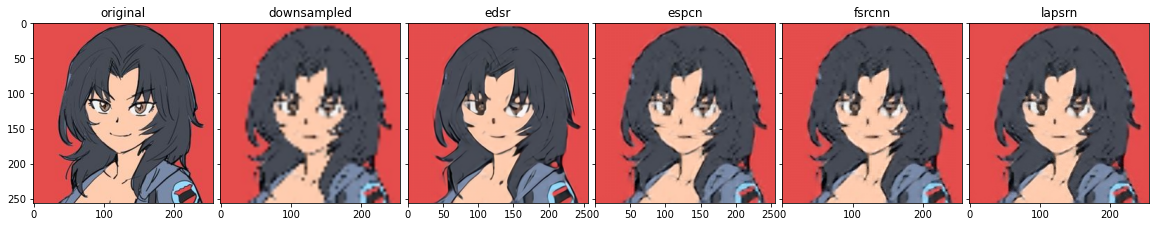

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid

def plot_images(images, titles):
    fig = plt.figure(figsize=(20., 8.))
    grid = ImageGrid(fig, 111, nrows_ncols=(1, len(images)), axes_pad=0.1)

    i = 0
    for ax, img in zip(grid, images):
        ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        ax.set_title(titles[i])
        i += 1
    plt.show()

img_small_resize = cv2.resize(img_small, (img.shape[0], img.shape[1]))

titles = ["original", "downsampled", "edsr", "espcn", "fsrcnn", "lapsrn"]
images = [img, img_small_resize, img_upscaled1, img_upscaled2, img_upscaled3, img_upscaled4]
plot_images(images, titles)

### some theory

Each pretrained model generate different scaling as notified in its filename

**EDSR**<hr>
https://arxiv.org/pdf/1707.02921.pdf

> * RESNET style architecture, without any batch normalization
> * Residual scaling with factor 0.1 is used in each residual block to counter instability in larger models.
> * Constant scaling layers are placed after last convolution layers.
> ReLu activation layers are not used after the residual blocks

**ESPCN** <hr>
https://arxiv.org/pdf/1609.05158.pdf

> * base structure inspired by SRCNN
> * upscaling layers are only deployed at the end of the network to ensure complex operations occurring in the model happen on lower dimensions, which makes it fast
> * Extract features maps in low resolution, then apply complex upscaling filters for super resolution.

> * sub-pixel convolution layers are utilized instead of convolution layers.
> * sub-pixel convolution layer is utilized in the last layer to produce the high-resolution map
> * They found that Tanh activation function works much better than the standard ReLu function.

**FSRCNN** <hr>
https://arxiv.org/pdf/1608.00367.pdf

> * base structure inspired by SRCNN
> * upscaling layers are only deployed at the end of the network to ensure complex operations occurring in the model happen on lower dimensions, which makes it fast
> * Architecure starts with convolution layers with filtersize of 5 instead of 9 as in SRCNN.
> * For shrinking layers to decrease computation cost filter size of 1x1 is used.
> * uses deconvolutional layers for upsampling.
> * PReLu was used as activation function

**LapSRN** <hr>
https://arxiv.org/pdf/1710.01992.pdf

> * It proposes to upscale gently till the end as a middle ground between the contrasting strategies of upscaling
> * Its name is based on Laplacian pyramids, and the architecture is basically like a pyramid upscaling the lower resolution image until the end.
> * The models consist of two branches: feature extraction and an image reconstruction branch.
Parameter sharing occurs among the different scales, i.e., 4x uses parameters from 2x model and so on. 
> * Different types of local skip connections like distinct-source skip connections and shared-source connections are used to avoid vanishing gradient problem in case of such deep models.
> * Charbonnier loss is used for the model’s loss function
> * Batch normalization layers are not used


## References

> https://docs.opencv.org/4.x/d8/d11/classcv_1_1dnn__superres_1_1DnnSuperResImpl.html<br>
>https://www.kaggle.com/datasets/scribbless/another-anime-face-dataset<br>
> https://learnopencv.com/super-resolution-in-opencv/<br>
> https://www.kaggle.com/code/akhileshdkapse/sr-super-resolution-gan-keras
